In [1]:
!nvidia-smi

Wed Oct 30 01:27:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660545 sha256=38fa634eb8c68a7a04f012c423bfff94446064cf309e3319d66bd4ecd91aa684
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 45개 중분류 컬럼 정의
DETAILED_COLUMNS = {
    '식료품·비주류음료': ['GROCERY_AM'],
    '의류·신발': ['CLOTH_AM', 'GOODS_AM'],
    '주거·수도·광열': ['ARCHIT_AM', 'BLDMNG_AM', 'SVC_AM'],
    '보건': ['HOS_AM', 'SANIT_AM', 'INSU_AM'],
    '교통': ['AUTOSL_AM', 'AUTOMNT_AM', 'FUEL_AM'],
    '통신': ['OFFCOM_AM'],
    '오락·문화': ['LEISURE_S_AM', 'LEISURE_P_AM', 'CULTURE_AM'],
    '교육': ['ACDM_AM', 'BOOK_AM'],
    '음식·숙박': ['RESTRNT_AM', 'HOTEL_AM'],
    '기타': ['FUNITR_AM', 'APPLNC_AM', 'KITWR_AM']
}

def prepare_detailed_data(df):
    """
    45개 중분류 컬럼을 모두 사용하여 데이터 준비
    """
    # 모든 중분류 컬럼 추출
    all_columns = []
    column_mapping = {}  # 컬럼과 대분류 매핑 저장

    for category, columns in DETAILED_COLUMNS.items():
        all_columns.extend(columns)
        for col in columns:
            column_mapping[col] = category

    # 데이터 준비
    prepared_data = df[all_columns].copy()

    # 결측치 처리
    prepared_data = prepared_data.fillna(0)

    # 스케일링
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(prepared_data)
    scaled_df = pd.DataFrame(scaled_data, columns=prepared_data.columns)

    # 기초 통계
    stats = pd.DataFrame({
        'category': [column_mapping[col] for col in all_columns],
        'mean': prepared_data.mean(),
        'std': prepared_data.std(),
        'missing': prepared_data.isnull().sum(),
        'zeros': (prepared_data == 0).sum()
    })

    print("=== 데이터 준비 완료 ===")
    print(f"전체 샘플 수: {len(prepared_data)}")
    print(f"전체 특성 수: {len(all_columns)}")
    print("\n=== 기초 통계 요약 ===")
    print(stats.head())

    return prepared_data, scaled_df, stats, column_mapping

In [4]:
# 데이터 로드
df = pd.read_csv('/content/edu_data_F.csv')

# 데이터 전처리
prepared_data, scaled_data, stats, column_mapping = prepare_detailed_data(df)

=== 데이터 준비 완료 ===
전체 샘플 수: 5382734
전체 특성 수: 23

=== 기초 통계 요약 ===
             category      mean        std  missing    zeros
GROCERY_AM  식료품·비주류음료  8.929091  32.971955        0  3891463
CLOTH_AM        의류·신발  2.491039  16.144352        0  4992112
GOODS_AM        의류·신발  0.830561   4.544311        0  5142655
ARCHIT_AM    주거·수도·광열  0.118841   1.083646        0  5318765
BLDMNG_AM    주거·수도·광열  5.444729  14.341979        0  4263495


In [5]:
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
import numpy as np
from time import time

# CUDA 커널 정의
cuda_kmeans_kernel = """
__global__ void calculate_distances(float *data, float *centroids, int *assignments,
                                  float *distances, int n_samples, int n_features, int n_clusters) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < n_samples) {
        float min_dist = 1e10;
        int best_cluster = 0;

        for (int c = 0; c < n_clusters; c++) {
            float dist = 0.0f;

            for (int f = 0; f < n_features; f++) {
                float diff = data[idx * n_features + f] - centroids[c * n_features + f];
                dist += diff * diff;
            }

            distances[idx * n_clusters + c] = dist;
            if (dist < min_dist) {
                min_dist = dist;
                best_cluster = c;
            }
        }

        assignments[idx] = best_cluster;
    }
}

__global__ void calculate_inertia(float *distances, int *assignments,
                                float *inertia, int n_samples, int n_clusters) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < n_samples) {
        int cluster = assignments[idx];
        atomicAdd(inertia, distances[idx * n_clusters + cluster]);
    }
}

__global__ void update_centroids(float *data, int *assignments, float *new_centroids,
                               int *cluster_sizes, int n_samples, int n_features, int n_clusters) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < n_samples) {
        int cluster = assignments[idx];
        atomicAdd(&cluster_sizes[cluster], 1);

        for (int f = 0; f < n_features; f++) {
            atomicAdd(&new_centroids[cluster * n_features + f],
                     data[idx * n_features + f]);
        }
    }
}

__global__ void calculate_silhouette(float *data, int *labels, float *a_scores,
                                   float *b_scores, int n_samples, int n_features,
                                   int n_clusters) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < n_samples) {
        int my_cluster = labels[idx];
        float a_sum = 0.0f;
        int a_count = 0;
        float min_b = 1e10f;

        // a(i) 계산: 같은 클러스터 내 평균 거리
        for (int j = 0; j < n_samples; j++) {
            if (j != idx && labels[j] == my_cluster) {
                float dist = 0.0f;
                for (int f = 0; f < n_features; f++) {
                    float diff = data[idx * n_features + f] - data[j * n_features + f];
                    dist += diff * diff;
                }
                a_sum += sqrt(dist);
                a_count++;
            }
        }

        // a_scores 계산
        if (a_count > 0) {
            a_scores[idx] = a_sum / a_count;
        } else {
            a_scores[idx] = 0.0f;
        }

        // b(i) 계산: 다른 클러스터와의 최소 평균 거리
        for (int c = 0; c < n_clusters; c++) {
            if (c != my_cluster) {
                float b_sum = 0.0f;
                int b_count = 0;

                for (int j = 0; j < n_samples; j++) {
                    if (labels[j] == c) {
                        float dist = 0.0f;
                        for (int f = 0; f < n_features; f++) {
                            float diff = data[idx * n_features + f] - data[j * n_features + f];
                            dist += diff * diff;
                        }
                        b_sum += sqrt(dist);
                        b_count++;
                    }
                }

                if (b_count > 0) {
                    float avg_b = b_sum / b_count;
                    min_b = min(min_b, avg_b);
                }
            }
        }

        b_scores[idx] = min_b;
    }
}
"""

class GPUKMeans:
    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

        # CUDA 커널 컴파일
        self.mod = SourceModule(cuda_kmeans_kernel)
        self.calculate_distances_kernel = self.mod.get_function("calculate_distances")
        self.calculate_inertia_kernel = self.mod.get_function("calculate_inertia")
        self.update_centroids_kernel = self.mod.get_function("update_centroids")
        self.calculate_silhouette_kernel = self.mod.get_function("calculate_silhouette")

    def fit(self, X):
        start_time = time()
        self.n_samples, self.n_features = X.shape
        X = X.astype(np.float32)

        # 초기 중심점 무작위 선택
        centroid_indices = np.random.choice(self.n_samples, self.n_clusters, replace=False)
        self.centroids = X[centroid_indices].astype(np.float32)

        # GPU 메모리 할당
        self.data_gpu = gpuarray.to_gpu(X)
        self.centroids_gpu = gpuarray.to_gpu(self.centroids)
        self.assignments_gpu = gpuarray.zeros(self.n_samples, dtype=np.int32)
        self.distances_gpu = gpuarray.zeros((self.n_samples, self.n_clusters), dtype=np.float32)

        # 블록 크기 설정
        self.block_size = 256
        self.grid_size = (self.n_samples + self.block_size - 1) // self.block_size

        # K-means 반복
        for iteration in range(self.max_iter):
            old_centroids = self.centroids.copy()

            # 거리 계산 및 할당
            self.calculate_distances_kernel(
                self.data_gpu, self.centroids_gpu, self.assignments_gpu,
                self.distances_gpu,
                np.int32(self.n_samples), np.int32(self.n_features),
                np.int32(self.n_clusters),
                block=(self.block_size, 1, 1), grid=(self.grid_size, 1)
            )

            # 새로운 중심점 계산
            new_centroids = np.zeros((self.n_clusters, self.n_features), dtype=np.float32)
            cluster_sizes = np.zeros(self.n_clusters, dtype=np.int32)

            new_centroids_gpu = gpuarray.to_gpu(new_centroids)
            cluster_sizes_gpu = gpuarray.to_gpu(cluster_sizes)

            self.update_centroids_kernel(
                self.data_gpu, self.assignments_gpu, new_centroids_gpu,
                cluster_sizes_gpu, np.int32(self.n_samples),
                np.int32(self.n_features), np.int32(self.n_clusters),
                block=(self.block_size, 1, 1), grid=(self.grid_size, 1)
            )

            # CPU로 데이터 복사
            new_centroids = new_centroids_gpu.get()
            cluster_sizes = cluster_sizes_gpu.get()

            # 중심점 업데이트
            for i in range(self.n_clusters):
                if cluster_sizes[i] > 0:
                    new_centroids[i] /= cluster_sizes[i]

            self.centroids = new_centroids
            self.centroids_gpu = gpuarray.to_gpu(self.centroids)

            # Inertia 계산
            inertia_gpu = gpuarray.zeros(1, dtype=np.float32)
            self.calculate_inertia_kernel(
                self.distances_gpu, self.assignments_gpu, inertia_gpu,
                np.int32(self.n_samples), np.int32(self.n_clusters),
                block=(self.block_size, 1, 1), grid=(self.grid_size, 1)
            )
            self.inertia_ = float(inertia_gpu.get())

            # 수렴 확인
            if np.all(np.abs(old_centroids - self.centroids) < self.tol):
                break

        self.labels_ = self.assignments_gpu.get()
        self.cluster_centers_ = self.centroids
        self.processing_time_ = time() - start_time

        return self

    def calculate_silhouette(self, X):
        """
        GPU로 Silhouette score 계산
        """
        n_samples = X.shape[0]

        # GPU 메모리 할당
        a_scores_gpu = gpuarray.zeros(n_samples, dtype=np.float32)
        b_scores_gpu = gpuarray.zeros(n_samples, dtype=np.float32)

        # Silhouette 계산
        self.calculate_silhouette_kernel(
            self.data_gpu, self.assignments_gpu,
            a_scores_gpu, b_scores_gpu,
            np.int32(n_samples), np.int32(self.n_features),
            np.int32(self.n_clusters),
            block=(self.block_size, 1, 1), grid=(self.grid_size, 1)
        )

        # 결과 가져오기
        a_scores = a_scores_gpu.get()
        b_scores = b_scores_gpu.get()

        # Silhouette score 계산
        s_scores = (b_scores - a_scores) / np.maximum(a_scores, b_scores)
        return np.mean(s_scores)

def run_clustering_analysis(data, k_range=(3,10)):
    """
    여러 k값에 대해 클러스터링 수행
    """
    results = {}

    for k in range(k_range[0], k_range[1] + 1):
        print(f"\nRunning clustering for k={k}")
        kmeans = GPUKMeans(n_clusters=k)
        kmeans.fit(data)

        # Silhouette score 계산
        silhouette = kmeans.calculate_silhouette(data)

        # 클러스터별 분석
        cluster_analysis = {}
        for i in range(k):
            mask = kmeans.labels_ == i
            cluster_analysis[f'Cluster {i}'] = {
                'size': np.sum(mask),
                'center': kmeans.cluster_centers_[i]
            }

        results[k] = {
            'labels': kmeans.labels_,
            'centroids': kmeans.cluster_centers_,
            'inertia': kmeans.inertia_,
            'silhouette': silhouette,
            'processing_time': kmeans.processing_time_,
            'cluster_analysis': cluster_analysis
        }

        print(f"Processing time: {kmeans.processing_time_:.2f} seconds")
        print(f"Inertia: {kmeans.inertia_:.2f}")
        print(f"Silhouette score: {silhouette:.3f}")

    return results

In [12]:
def visualize_clustering_results(results, data):
    """
    GPU K-means 클러스터링 결과 시각화
    """
    k_values = list(results.keys())

    # 결과 메트릭 수집
    inertias = [results[k]['inertia'] for k in k_values]
    processing_times = [results[k]['processing_time'] for k in k_values]

    # 1. 주요 메트릭 시각화 (2x2 서브플롯)
    fig = plt.figure(figsize=(20, 15))

    # 1-1. Elbow curve
    plt.subplot(221)
    plt.plot(k_values, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Curve')
    plt.grid(True)

    # 1-2. 처리 시간
    plt.subplot(222)
    plt.plot(k_values, processing_times, 'go-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Processing Time (seconds)')
    plt.title('Processing Time by Number of Clusters')
    plt.grid(True)

    # 1-3. 클러스터 크기 분포
    plt.subplot(223)
    cluster_sizes_data = []
    cluster_labels = []
    for k in k_values:
        sizes = [analysis['size'] for analysis in results[k]['cluster_analysis'].values()]
        cluster_sizes_data.extend(sizes)
        cluster_labels.extend([f'k={k}'] * len(sizes))

    sns.boxplot(x=cluster_labels, y=cluster_sizes_data)
    plt.xticks(rotation=45)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Cluster Size')
    plt.title('Distribution of Cluster Sizes')

    # 1-4. 클러스터 간 거리 분포
    plt.subplot(224)
    for k in k_values:
        centroids = results[k]['centroids']
        distances = []
        for i in range(len(centroids)):
            for j in range(i+1, len(centroids)):
                dist = np.linalg.norm(centroids[i] - centroids[j])
                distances.append(dist)
        plt.scatter([k]*len(distances), distances, alpha=0.5)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inter-cluster Distance')
    plt.title('Distribution of Inter-cluster Distances')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 2. 분석 결과 출력
    print("\n=== Clustering Analysis Results ===")

    # Elbow method - 2차 미분의 최대값 지점 찾기
    k_array = np.array(k_values)
    inertia_array = np.array(inertias)
    second_derivative = np.diff(np.diff(inertia_array))
    elbow_idx = np.argmax(np.abs(second_derivative)) + 1
    best_k_elbow = k_values[elbow_idx]

    print("\nOptimal k Analysis:")
    print(f"- By Elbow method: k={best_k_elbow}")

    print("\nDetailed Metrics for each k:")
    for k in k_values:
        print(f"\nk={k}:")
        print(f"  Inertia: {results[k]['inertia']:.0f}")
        print(f"  Processing Time: {results[k]['processing_time']:.2f} seconds")
        sizes = [analysis['size'] for analysis in results[k]['cluster_analysis'].values()]
        print(f"  Cluster Sizes: {sizes}")

    # 3. 최적 k에 대한 상세 분석
    best_k = best_k_elbow
    print(f"\n=== Detailed Analysis for Best k={best_k} ===")

    # 클러스터별 특성
    cluster_analysis = results[best_k]['cluster_analysis']
    for cluster, details in cluster_analysis.items():
        print(f"\n{cluster}:")
        print(f"Size: {details['size']} samples")
        print(f"Center features (top 5 absolute values):")
        center = details['center']
        top_features = np.argsort(np.abs(center))[-5:]
        for idx in top_features:
            print(f"Feature {idx}: {center[idx]:.3f}")

def plot_cluster_details(results, k, data_columns):
    """
    특정 k값에 대한 클러스터 상세 분석
    """
    plt.figure(figsize=(15, 10))

    # 중심점 히트맵
    centers = results[k]['centroids']
    sns.heatmap(centers, cmap='RdBu_r', center=0,
                xticklabels=data_columns,
                yticklabels=[f'Cluster {i}' for i in range(k)])
    plt.title(f'Cluster Centers Heatmap (k={k})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 클러스터별 크기 분포
    sizes = [analysis['size'] for analysis in results[k]['cluster_analysis'].values()]
    plt.figure(figsize=(10, 5))
    plt.bar(range(k), sizes)
    plt.title(f'Cluster Sizes (k={k})')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Samples')
    plt.grid(True, alpha=0.3)
    plt.show()

In [10]:
# 3. GPU 클러스터링 실행
# k=3부터 10까지 분석
results = run_clustering_analysis(scaled_data.values, k_range=(3, 10))


Running clustering for k=3


<ipython-input-5-5dc2c0ad2f96>:140: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.inertia_ = float(inertia_gpu.get())


Processing time: 10.32 seconds
Inertia: 114305472.00

Running clustering for k=4
Processing time: 6.74 seconds
Inertia: 111097688.00

Running clustering for k=5
Processing time: 8.36 seconds
Inertia: 108748088.00

Running clustering for k=6
Processing time: 10.52 seconds
Inertia: 106667208.00

Running clustering for k=7
Processing time: 7.60 seconds
Inertia: 105478296.00

Running clustering for k=8
Processing time: 7.03 seconds
Inertia: 102270888.00

Running clustering for k=9
Processing time: 10.09 seconds
Inertia: 101566544.00

Running clustering for k=10
Processing time: 7.35 seconds
Inertia: 98294488.00


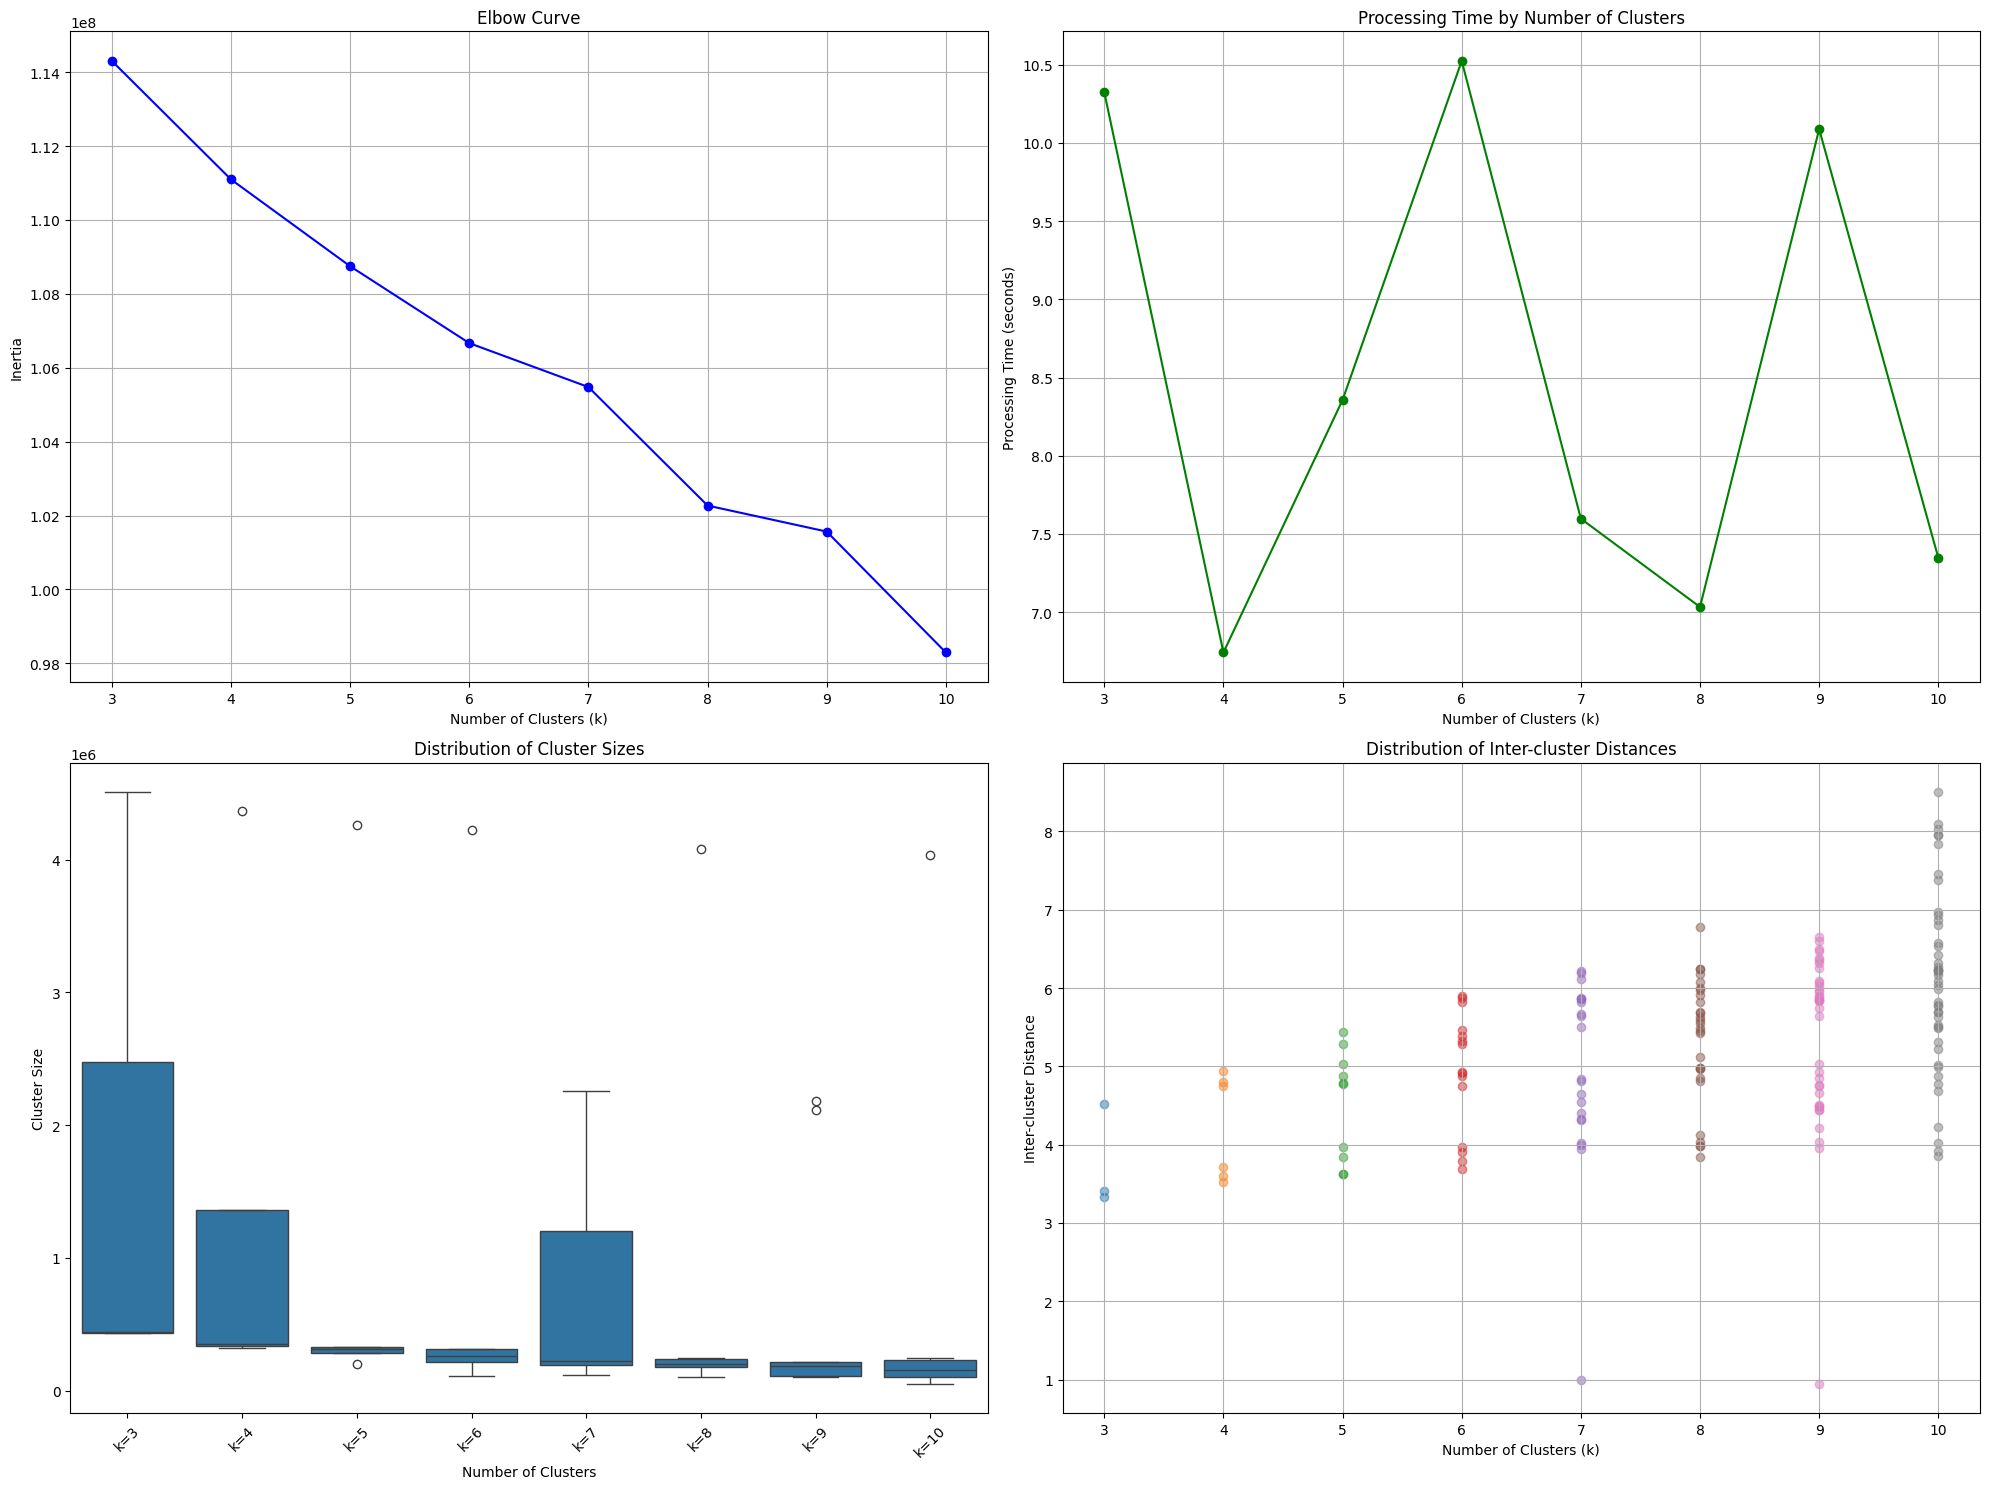


=== Clustering Analysis Results ===

Optimal k Analysis:
- By Elbow method: k=9

Detailed Metrics for each k:

k=3:
  Inertia: 114305472
  Processing Time: 10.32 seconds
  Cluster Sizes: [440106, 434497, 4508131]

k=4:
  Inertia: 111097688
  Processing Time: 6.74 seconds
  Cluster Sizes: [320740, 356072, 4365242, 340680]

k=5:
  Inertia: 108748088
  Processing Time: 8.36 seconds
  Cluster Sizes: [326953, 284279, 198888, 4260018, 312596]

k=6:
  Inertia: 106667208
  Processing Time: 10.52 seconds
  Cluster Sizes: [4223556, 212493, 225783, 316488, 113404, 291010]

k=7:
  Inertia: 105478296
  Processing Time: 7.60 seconds
  Cluster Sizes: [2180046, 113616, 177105, 223155, 207340, 224860, 2256612]

k=8:
  Inertia: 102270888
  Processing Time: 7.03 seconds
  Cluster Sizes: [4078801, 233555, 205591, 249074, 201055, 105854, 200869, 107935]

k=9:
  Inertia: 101566544
  Processing Time: 10.09 seconds
  Cluster Sizes: [162228, 2180961, 104890, 2111437, 106810, 113163, 211777, 181814, 209654]

k

In [13]:
# 4. 기본 시각화
visualize_clustering_results(results, scaled_data)

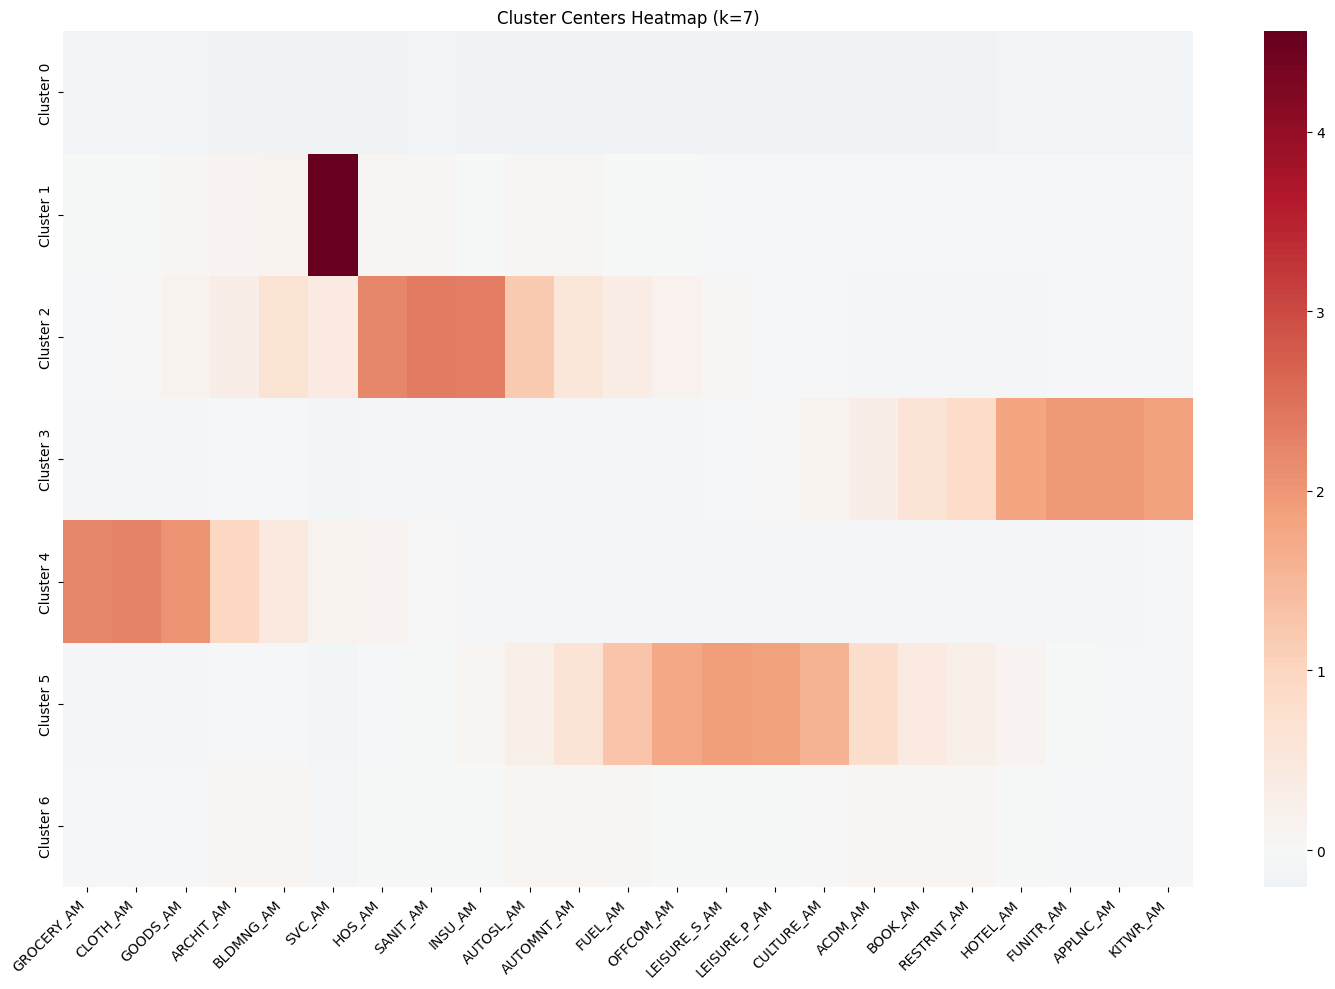

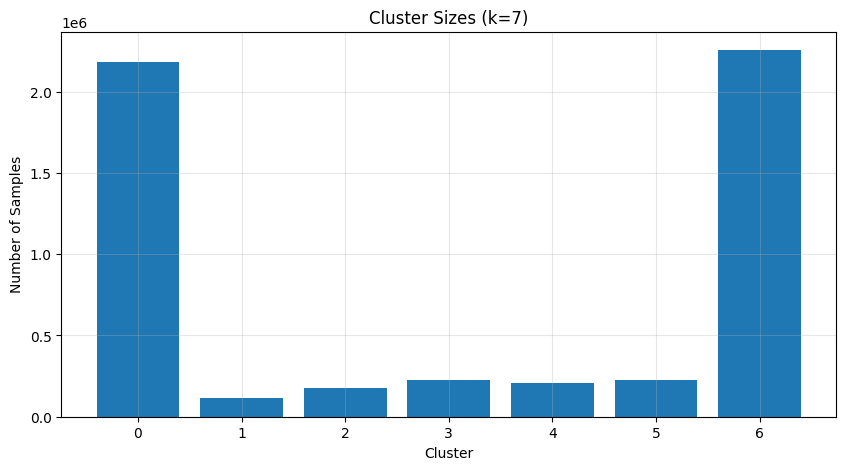

In [14]:
# 5. 특정 k값에 대한 상세 분석
plot_cluster_details(results, k=7, data_columns=scaled_data.columns)